# Chapter 3 - linear neural networks

### Imports

In [3]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import numpy as np
import time
import random
import pandas as pd
from torch.utils import data
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils import data

## Linear regression

In [21]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import numpy as np
import time
import random

In [3]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [4]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

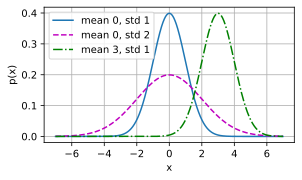

In [5]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## Linear Regression Implementation from Scratch

In [170]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [171]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.3123, -1.8417]) 
label: tensor([7.8246])


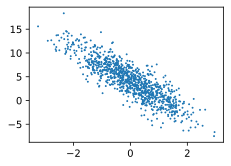

In [172]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(d2l.numpy(features[:, 1]), d2l.numpy(labels), 1);

In [173]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [174]:
# initialise weights - Notice the requires grad which allows for auto diff
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [175]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [176]:
# Stochastic gradient descent!
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent.
    
    The parameters are updated using the
    data and inplace subtract. The data attribute
    ensures that the operation is not tracked
    """
    
    for param in params:
        param.data.sub_(lr*param.grad/batch_size)
        param.grad.data.zero_()

In [177]:
# # why we need .data
# l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
# # Compute gradient on `l` with respect to [`w`, `b`]
# l.sum().backward()

# w

# w.grad

# w.sub_(lr*w.grad/batch_size)

In [178]:
batch_size = 10
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035860
epoch 2, loss 0.000133
epoch 3, loss 0.000050


In [179]:
# with torch.no_grad():
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-9.2506e-05, -1.4114e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0008], grad_fn=<RsubBackward1>)


## Concise linear regression

In [181]:

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [206]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [208]:
# next(iter(data_iter))

In [232]:
# `nn` is an abbreviation for neural networks

net = nn.Sequential(nn.Linear(2, 1))

In [233]:
# initialise values of net
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [234]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [235]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000197
epoch 2, loss 0.000100
epoch 3, loss 0.000100


In [236]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([0.0004, 0.0003])
error in estimating b: tensor([-0.0001])


## Softmax Regression

In [2]:
# no code in this section

## The Image Classification Dataset 

In [6]:
d2l.use_svg_display()

In [73]:
# `ToTensor` converts the image data from PIL type to 32-bit floating point
# tensors. It divides all numbers by 255 so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

resize=128
trans = [transforms.ToTensor()]
if resize:
    trans.insert(0, transforms.Resize(resize))
trans = transforms.Compose(trans)
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [74]:
mnist_train[0][0].shape

torch.Size([1, 128, 128])

In [75]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [76]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [77]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(d2l.numpy(img))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

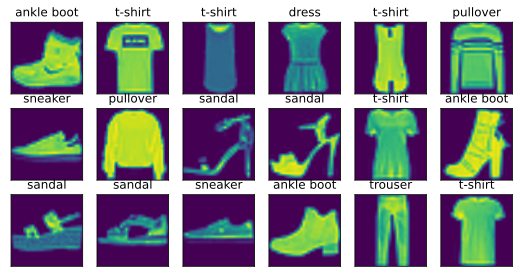

In [78]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, resize, resize), 3, 6, titles=get_fashion_mnist_labels(y));

In [79]:
batch_size = 256

def get_dataloader_workers():  #@save
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [80]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'4.25 sec'

In [81]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [82]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [ ]:
# excellent